# Use Monthly IP and LEI to Predict Quarterly GDP

In this notebook, we use monthly industrial producation % yoy growth (IP_YOY) and monthly leading indicator %yoy growth (LEI_YOY) to predict quarterly gdp % yoy growth (GDP_CYOY).

The midaspy package is modified to allow for two high frequency indicators. Specifically, the following functions are added: mix_freq2, ssr2, jacobian2, estimate2, forecast2, midas_adl2, fixed_window2, rolling2, recursive2. The new functions can be used for both MIDAS and autoregressive MIDAS by changing the value of ylag. For the polynomial b in MIDAS, we can use exponential Almon weights (‘expalmon’) or beta weights (‘beta’). For the model training window size, we can use fixed window (‘fixed’), rolling basis (‘rolling’) or recursive (‘recursive’). In addition, the original estimate and forecast functions are modified to allow for different number of low frequency data lags.

We can change the parameters and training window to evaluate the forecast accuracy of MIDAS. As a measure of accuracy, the relative MSE will be used in our application, which is defined as MSE of MIDAS divided by the MSE of the benchmark forecast. The benchmark forecast is the in-sample mean of GDP growth recomputed every recursion.

In [3]:
# %matplotlib inline
# 1.5.3 pandas
import datetime
import numpy as np
import pandas as pd


from midas.mix import mix_freq, mix_freq2
from midas.adl import estimate, forecast, midas_adl, rmse, estimate2,forecast2, midas_adl2

In [4]:
import pandas as pd
print(pd.__version__)

1.5.3


In [7]:
# Read data
gdp = pd.read_csv('./data/GDP.csv', parse_dates=['DATE'], index_col='DATE')
ip = pd.read_csv('./data/IP.csv', parse_dates=['DATE'], index_col='DATE')
lei = pd.read_csv('./data/LEI.csv', parse_dates=['DATE'], index_col='DATE')
gdp.tail()

,GDP_CYOY
DATE,
2017-03-31,2.0
2017-06-30,2.2
2017-09-30,2.3
2017-12-31,2.6
2018-03-31,2.8


In [8]:
ip.tail()

,IP_YOY
DATE,
2017-12-31,2.85
2018-01-31,2.71
2018-02-28,3.51
2018-03-31,3.71
2018-04-30,3.50


In [9]:
lei.tail()

,LEI_YOY
DATE,
2017-12-31,5.7
2018-01-31,5.9
2018-02-28,6.4
2018-03-31,6.2
2018-04-30,6.4


<Axes: xlabel='DATE'>

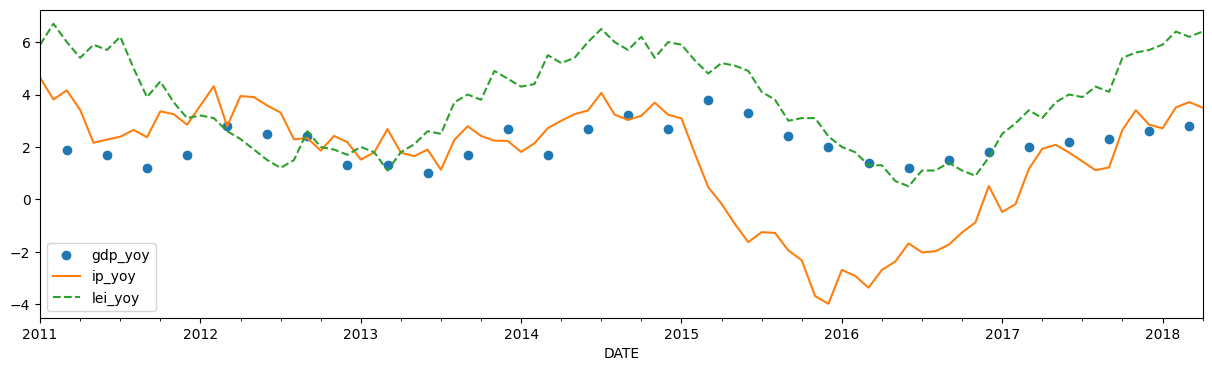

In [10]:
# Plot the sample data
df = pd.concat([gdp, ip, lei], axis=1)
df.columns = ['gdp_yoy','ip_yoy','lei_yoy']
df[['gdp_yoy','ip_yoy','lei_yoy']].loc['2011-1-31':].plot(figsize=(15,4), style=['o','-','--'])

## Mixing Frequencies

The first step is to do the actual frequency mixing.  In this case we're mixing monthly data (industrial producation % yoy growth, leading indicator %yoy) with quarterly data (gdp % yoy growth).  

In [11]:
print(gdp.GDP_CYOY)

DATE
2011-03-31    1.9
2011-06-30    1.7
2011-09-30    1.2
2011-12-31    1.7
2012-03-31    2.8
2012-06-30    2.5
2012-09-30    2.4
2012-12-31    1.3
2013-03-31    1.3
2013-06-30    1.0
2013-09-30    1.7
2013-12-31    2.7
2014-03-31    1.7
2014-06-30    2.7
2014-09-30    3.2
2014-12-31    2.7
2015-03-31    3.8
2015-06-30    3.3
2015-09-30    2.4
2015-12-31    2.0
2016-03-31    1.4
2016-06-30    1.2
2016-09-30    1.5
2016-12-31    1.8
2017-03-31    2.0
2017-06-30    2.2
2017-09-30    2.3
2017-12-31    2.6
2018-03-31    2.8
Name: GDP_CYOY, dtype: float64


In [12]:
y, yl, x1, x2, yf, ylf, x1f, x2f =mix_freq2(gdp.GDP_CYOY, ip.IP_YOY,lei.LEI_YOY, "3m","3m", 1, 2,
                                 start_date=datetime.datetime(2011,3,31),
                                 end_date=datetime.datetime(2013,3,31))

/app/midas/mix.py:119: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_hf1 = hf_data1.index.get_loc(lfdate, method='bfill')  # @todo Find a more efficient way
/app/midas/mix.py:120: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_hf2 = hf_data2.index.get_loc(lfdate, method='bfill')


## Fitting the Model

Because of the form of the MIDAS model, fitting the model requires using non-linear least squares.  For now, if you call the __estimate2__ function directly, you'll get back a results of type scipy.optimize.optimize.OptimizeResult. We use data from 2011-3-31 to 2013-3-31 to fit the model and use the rest of data to forecast.

In [13]:
res = estimate2(y, yl, x1, x2, poly1='expalmon', poly2='expalmon')
res.x
#opt params [beta0, beta1, beta2, theta11, theta12, theta21, theta22, lambda]

/app/midas/adl.py:85: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(np.concatenate([np.ones((len(xw1), 1)), xw1.reshape((len(xw1), 1)), xw2.reshape((len(xw2), 1)), yl], axis=1), y)[0]


array([ 0.62437404,  0.81585015, -0.19729317, 19.58709509, -7.23961178,
        1.01342835,  9.93224433, -0.20844232])

You can also call __forecast2__ directly.  This will use the optimization results returned from __eatimate2__ to produce a forecast for every date in the index of the forecast inputs (here x1f, x2f and ylf):

In [14]:
fc = forecast2(x1f, x2f, ylf, res, poly1='expalmon',poly2='expalmon')
forecast_df = fc.join(yf)
forecast_df['gap'] = forecast_df.yfh - forecast_df.GDP_CYOY
forecast_df

,yfh,GDP_CYOY,gap
DATE,,,
2013-06-30,1.528353,1.0,0.528353
2013-09-30,0.990148,1.7,-0.709852
2013-12-31,1.546407,2.7,-1.153593
2014-03-31,0.607871,1.7,-1.092129
2014-06-30,1.825257,2.7,-0.874743
2014-09-30,2.250579,3.2,-0.949421
2014-12-31,1.362318,2.7,-1.337682
2015-03-31,1.529287,3.8,-2.270713
2015-06-30,-1.296682,3.3,-4.596682


## The midas_adl and midas_adl2 function

The __midas\_adl__ and __midas\_adl2__ function wraps up frequency-mixing, fitting, and forecasting into one process.  The default mode of forecasting is _rolling_.

### Use one monthly indicator

In [15]:
# use IP_YOY
rmse_fc1, fc1 = midas_adl(gdp.GDP_CYOY, ip.IP_YOY, 
                         start_date=datetime.datetime(2011,3,31),
                         end_date=datetime.datetime(2013,3,31),
                         xlag="3m",
                         ylag=1,
                         horizon=1,
                         poly='expalmon',
                         method='rolling')
rmse_fc1

/app/midas/mix.py:54: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_hf = hf_data.index.get_loc(lfdate, method='bfill')  # @todo Find a more efficient way
/app/midas/adl.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(np.concatenate([np.ones((len(xw), 1)), xw.reshape((len(xw), 1)), yl], axis=1), y)[0]
/app/midas/mix.py:54: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_hf = hf_data.index.get_loc(lfdate, method='bfill')  # @todo Find a more efficient way
/app/midas/adl.py:32: FutureWarning: `rcond` 

0.852399399907665

In [16]:
# use LEI_YOY
rmse_fc2, fc2 = midas_adl(gdp.GDP_CYOY, lei.LEI_YOY, 
                         start_date=datetime.datetime(2011,3,31),
                         end_date=datetime.datetime(2013,3,31),
                         xlag="3m",
                         ylag=1,
                         horizon=1,
                         poly='expalmon',
                         method='rolling')
rmse_fc2

/app/midas/mix.py:54: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_hf = hf_data.index.get_loc(lfdate, method='bfill')  # @todo Find a more efficient way
/app/midas/adl.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(np.concatenate([np.ones((len(xw), 1)), xw.reshape((len(xw), 1)), yl], axis=1), y)[0]
/app/midas/mix.py:54: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_hf = hf_data.index.get_loc(lfdate, method='bfill')  # @todo Find a more efficient way
/app/midas/adl.py:32: FutureWarning: `rcond` 

0.6687371785699303

### Use two monthly indicator

In [17]:
# use IP_YOY and LEI_YOY
rmse_fc, fc = midas_adl2(gdp.GDP_CYOY, ip.IP_YOY,lei.LEI_YOY, 
                         start_date=datetime.datetime(2011,3,31),
                         end_date=datetime.datetime(2013,3,31),
                         x1lag="3m",
                         x2lag="3m",
                         ylag=1,
                         horizon=1,
                         poly1='expalmon',
                         poly2='expalmon',
                         method='rolling')
rmse_fc

/app/midas/mix.py:119: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_hf1 = hf_data1.index.get_loc(lfdate, method='bfill')  # @todo Find a more efficient way
/app/midas/mix.py:120: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_hf2 = hf_data2.index.get_loc(lfdate, method='bfill')
/app/midas/adl.py:85: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(np.concatenate([np.ones((len(xw1), 1)), xw1.reshape((len(xw1), 1)), xw2.reshape((len(xw2), 1)), yl], axis=1), y)[0]
/app/midas/mix.py:119: FutureWarning: Passi

0.771034505878936

# Forecast quarterly GDP

In [18]:
# Set start date and end date
start_date=datetime.datetime(2011,3,31)
end_date=datetime.datetime(2013,3,31)

In [19]:
df_result=pd.DataFrame(index=ip.index, columns=['final_gdp_date'])
temp=df_result.iloc[2::3].reset_index()
for i in range(0,len(temp)):
    df_result['final_gdp_date'][i*3+2]=temp['DATE'][i].date()
df_result[['final_gdp_date','GDP_CYOY']]=df_result.join(gdp)[['final_gdp_date','GDP_CYOY']].fillna(method='bfill')

In [20]:
# To compute benchmark forecast
n_month=df_result.index.get_loc(end_date)-df_result.index.get_loc(start_date)
df_result['benchmark']=df_result['GDP_CYOY'].rolling(window=n_month).mean()
df_result

,final_gdp_date,GDP_CYOY,benchmark
DATE,,,
2011-01-31,2011-03-31,1.9,NaN
2011-02-28,2011-03-31,1.9,NaN
2011-03-31,2011-03-31,1.9,NaN
2011-04-30,2011-06-30,1.7,NaN
2011-05-31,2011-06-30,1.7,NaN
...,...,...,...
2017-12-31,2017-12-31,2.6,1.875000
2018-01-31,2018-03-31,2.8,1.933333
2018-02-28,2018-03-31,2.8,1.991667


Note: GDP_CYOY is actual GDP growth, and benchmark is the in-sample mean of GDP growth recomputed every recursion.

In [21]:
# Forecast_all, n is the max horizon, we will set n=3
def forecast_all(y_in, x1_in, x2_in, start_date, end_date, x1lag, x2lag, ylag,n, 
                 forecast_horizon, poly1, poly2, method='rolling'):
    forecast_result=[]
    rmse_result=[]
    for i in range(n):
        rmse,fc=midas_adl2(y_in, x1_in, x2_in, start_date=start_date, end_date=end_date,
                           x1lag=x1lag, x2lag=x2lag, ylag=ylag, horizon=i,
                           poly1=poly1, poly2=poly2, method=method)
        forecast_result.append(fc)
        rmse_result.append(rmse)
    return forecast_result, rmse_result

In [22]:
# Define a function to assist storing forecast gdp to df_result
def store_gdp(df0,df1,df2,df):
    df0=df0.reset_index()
    df0['DATE']=df0['index']
    df0=df0.drop(['index','targets'],axis=1)
    
    df1=df1.reset_index()
    df1['DATE']=df1['index']
    df1=df1.drop(['index','targets'],axis=1)
    
    df2=df2.reset_index()
    df2['DATE']=df2['index']
    df2=df2.drop(['index','targets'],axis=1)
    
    df_result=df.copy()
    df_result=df_result.reset_index()
    df_result=df_result.merge(df2,how='left',on='DATE')
    df_result=df_result.merge(df1,how='left',on='DATE')
    df_result=df_result.merge(df0,how='left',on='DATE')
    
    df_result['preds_x']=df_result['preds_x'].shift(-2)
    df_result['preds_y']=df_result['preds_y'].shift(-1)
    df_result=df_result.fillna(0)
    df_result['forecast_gdp']=df_result['preds_x']+df_result['preds_y']+df_result['preds']
    df_result=df_result.drop(['preds_x','preds_y','preds'],axis=1).set_index('DATE')
    
    return df_result

## Use MIDAS with two indicators on a rolling basis

Both two indicators use lags of 3 months.

In [23]:
# n=3, ylag=0, method='rolling'
df_fc1, rmse1=forecast_all(gdp.GDP_CYOY, ip.IP_YOY,lei.LEI_YOY, start_date, end_date, 
                           x1lag='3m',x2lag='3m', ylag=0, n=3, forecast_horizon=1, 
                           poly1='expalmon', poly2='expalmon', method='rolling')

/app/midas/mix.py:119: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_hf1 = hf_data1.index.get_loc(lfdate, method='bfill')  # @todo Find a more efficient way
/app/midas/mix.py:120: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_hf2 = hf_data2.index.get_loc(lfdate, method='bfill')
/app/midas/adl.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(np.concatenate([np.ones((len(xw1), 1)), xw1.reshape((len(xw1), 1)), xw2.reshape((len(xw2), 1))], axis=1), y)[0]
/app/midas/mix.py:119: FutureWarning: Passing 

In [24]:
rmse1

[0.6948878574527242, 0.7108775036393278, 0.7175905352595503]

In [25]:
# Store forecast results in df_result
df_result1=store_gdp(df_fc1[0],df_fc1[1],df_fc1[2],df_result)

In [26]:
# Forecast results
df_result1.iloc[df_result1.index.get_loc(end_date)+1:]

,final_gdp_date,GDP_CYOY,benchmark,forecast_gdp
DATE,,,,
2013-04-30,2013-06-30,1.0,1.833333,1.516998
2013-05-31,2013-06-30,1.0,1.804167,1.525924
2013-06-30,2013-06-30,1.0,1.775000,1.332685
2013-07-31,2013-09-30,1.7,1.795833,0.736541
2013-08-31,2013-09-30,1.7,1.816667,0.833724
...,...,...,...,...
2017-12-31,2017-12-31,2.6,1.875000,2.906149
2018-01-31,2018-03-31,2.8,1.933333,0.000000
2018-02-28,2018-03-31,2.8,1.991667,0.000000


## Measure forecast accuracy

We use relative MSE as a measure of accuracy. Relative MSE is defined as MSE of MIDAS divided by the MSE of the benchmark forecast. The benchmark forecast is the in-sample mean of GDP growth recomputed every recursion.

In [27]:
temp=df_result1[df_result1['forecast_gdp']!=0]
relative_mse=((temp['GDP_CYOY']-temp['forecast_gdp'])**2).mean()/((temp['GDP_CYOY']-temp['benchmark'])**2).mean()
relative_mse

0.7431229090597246